In [1]:
import numpy as np
import pyldpc as ldpc
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
from utils_f import load_code
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device='cuda:1'

In [3]:
H_filename = './source/hamming.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

In [4]:
class Decoder(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(Decoder, self).__init__()
        self.W_cv = torch.nn.Parameter(0.5*torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_cv.requires_grad = True
        self.B_cv = torch.nn.Parameter(0.5*torch.abs(torch.randn((num_iterations, num_edges))))
        self.B_cv.requires_grad = True
        self.W_vc = torch.nn.Parameter(0.5*torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(soft_input)
        output = output.T
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1]))       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1]))
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [5]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

            
            
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        if (np.mod(epoch+1,2)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

## Create dataloader

In [6]:
train_size = 100000


def gen():
    messages = np.random.randint(0,2,[train_size,k])
    codewords = messages @ G % 2
    BPSK_codewords = (0.5 - codewords.astype(np.float32)) * 2.0
    soft_input = np.zeros_like(BPSK_codewords)
    SNRs = np.arange(1,6)
    for i in range(0,len(SNRs)):
        sigma = np.sqrt(1. / (2 * (np.float(k)/np.float(n)) * 10**(SNRs[i]/10)))
        noise = sigma * np.random.randn(train_size//len(SNRs),n)
        start_idx = train_size*i//len(SNRs)
        end_idx = train_size*(i+1)//len(SNRs)
        soft_input[start_idx:end_idx,:] = BPSK_codewords[start_idx:end_idx,:] + noise
        soft_input = 2*soft_input / (sigma**2)
    return soft_input, codewords
    
    
    
def update_loaders():


    soft_input_train, codewords_train = gen()
    train_X = torch.Tensor(soft_input_train) # transform to torch tensor
    train_y = torch.Tensor(codewords_train)
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y) # create your datset
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20000, shuffle=True) # create your dataloader


    soft_input_test, codewords_test = gen()
    test_X = torch.Tensor(soft_input_test) # transform to torch tensor
    test_y = torch.Tensor(codewords_test)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y) # create your datset
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20000, shuffle=True) # create your dataloader
    return training_loader, test_loader

In [7]:
decoder = Decoder(num_iterations=5).to(device)
opt = torch.optim.Adam(decoder.parameters(), lr=0.1)
# opt = torch.optim.SGD(decoder.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

In [8]:
for i in range(1):
    print(f'{i+1}/5')
    training_loader, test_loader = update_loaders()
    train(training_loader, test_loader, decoder, criterion, opt, n_epochs=60)

1/5


  3%|███▉                                                                                                                   | 2/60 [00:04<01:59,  2.07s/it]

[Epoch 2] train loss: 7.923; train acc: 1.74; test loss: 7.655; test acc: 2.36


  7%|███████▉                                                                                                               | 4/60 [00:08<01:52,  2.02s/it]

[Epoch 4] train loss: 7.116; train acc: 3.64; test loss: 6.808; test acc: 4.33


 10%|███████████▉                                                                                                           | 6/60 [00:12<01:48,  2.00s/it]

[Epoch 6] train loss: 6.716; train acc: 4.57; test loss: 6.566; test acc: 4.89


 13%|███████████████▊                                                                                                       | 8/60 [00:16<01:44,  2.02s/it]

[Epoch 8] train loss: 6.293; train acc: 5.56; test loss: 6.336; test acc: 5.43


 17%|███████████████████▋                                                                                                  | 10/60 [00:20<01:40,  2.02s/it]

[Epoch 10] train loss: 6.347; train acc: 5.43; test loss: 6.327; test acc: 5.45


 20%|███████████████████████▌                                                                                              | 12/60 [00:24<01:38,  2.05s/it]

[Epoch 12] train loss: 6.316; train acc: 5.51; test loss: 6.293; test acc: 5.53


 23%|███████████████████████████▌                                                                                          | 14/60 [00:28<01:33,  2.04s/it]

[Epoch 14] train loss: 6.172; train acc: 5.84; test loss: 6.121; test acc: 5.93


 27%|███████████████████████████████▍                                                                                      | 16/60 [00:32<01:29,  2.04s/it]

[Epoch 16] train loss: 6.154; train acc: 5.88; test loss: 6.180; test acc: 5.80


 30%|███████████████████████████████████▍                                                                                  | 18/60 [00:36<01:26,  2.05s/it]

[Epoch 18] train loss: 6.181; train acc: 5.82; test loss: 6.161; test acc: 5.84


 33%|███████████████████████████████████████▎                                                                              | 20/60 [00:40<01:21,  2.04s/it]

[Epoch 20] train loss: 6.177; train acc: 5.83; test loss: 6.155; test acc: 5.86


 37%|███████████████████████████████████████████▎                                                                          | 22/60 [00:44<01:18,  2.07s/it]

[Epoch 22] train loss: 6.123; train acc: 5.96; test loss: 6.100; test acc: 5.98


 40%|███████████████████████████████████████████████▏                                                                      | 24/60 [00:49<01:13,  2.05s/it]

[Epoch 24] train loss: 6.085; train acc: 6.05; test loss: 6.067; test acc: 6.06


 43%|███████████████████████████████████████████████████▏                                                                  | 26/60 [00:53<01:09,  2.06s/it]

[Epoch 26] train loss: 6.075; train acc: 6.07; test loss: 6.076; test acc: 6.04


 47%|███████████████████████████████████████████████████████                                                               | 28/60 [00:57<01:05,  2.05s/it]

[Epoch 28] train loss: 6.153; train acc: 5.89; test loss: 6.170; test acc: 5.82


 50%|███████████████████████████████████████████████████████████                                                           | 30/60 [01:01<01:01,  2.05s/it]

[Epoch 30] train loss: 6.200; train acc: 5.78; test loss: 6.181; test acc: 5.79


 53%|██████████████████████████████████████████████████████████████▉                                                       | 32/60 [01:05<00:58,  2.08s/it]

[Epoch 32] train loss: 6.231; train acc: 5.71; test loss: 6.243; test acc: 5.65


 57%|██████████████████████████████████████████████████████████████████▊                                                   | 34/60 [01:09<00:53,  2.06s/it]

[Epoch 34] train loss: 6.291; train acc: 5.57; test loss: 6.304; test acc: 5.52


 60%|██████████████████████████████████████████████████████████████████████▊                                               | 36/60 [01:13<00:49,  2.05s/it]

[Epoch 36] train loss: 6.243; train acc: 5.68; test loss: 6.218; test acc: 5.71


 63%|██████████████████████████████████████████████████████████████████████████▋                                           | 38/60 [01:17<00:45,  2.05s/it]

[Epoch 38] train loss: 6.129; train acc: 5.94; test loss: 6.107; test acc: 5.97


 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 40/60 [01:21<00:40,  2.04s/it]

[Epoch 40] train loss: 6.127; train acc: 5.95; test loss: 6.105; test acc: 5.97


 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 42/60 [01:26<00:36,  2.05s/it]

[Epoch 42] train loss: 6.098; train acc: 6.02; test loss: 6.089; test acc: 6.01


 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 44/60 [01:30<00:32,  2.05s/it]

[Epoch 44] train loss: 6.115; train acc: 5.98; test loss: 6.118; test acc: 5.94


 77%|██████████████████████████████████████████████████████████████████████████████████████████▍                           | 46/60 [01:34<00:28,  2.07s/it]

[Epoch 46] train loss: 6.149; train acc: 5.90; test loss: 6.145; test acc: 5.88


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 48/60 [01:38<00:24,  2.07s/it]

[Epoch 48] train loss: 6.126; train acc: 5.95; test loss: 6.156; test acc: 5.85


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 50/60 [01:42<00:20,  2.06s/it]

[Epoch 50] train loss: 6.119; train acc: 5.96; test loss: 6.089; test acc: 6.00


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 52/60 [01:46<00:16,  2.05s/it]

[Epoch 52] train loss: 6.111; train acc: 5.98; test loss: 6.113; test acc: 5.95


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 54/60 [01:50<00:12,  2.05s/it]

[Epoch 54] train loss: 6.115; train acc: 5.97; test loss: 6.045; test acc: 6.11


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 56/60 [01:54<00:08,  2.07s/it]

[Epoch 56] train loss: 6.603; train acc: 4.84; test loss: 6.701; test acc: 4.58


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 58/60 [01:58<00:04,  2.05s/it]

[Epoch 58] train loss: 6.744; train acc: 4.51; test loss: 6.750; test acc: 4.47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [02:03<00:00,  2.05s/it]

[Epoch 60] train loss: 6.790; train acc: 4.40; test loss: 6.725; test acc: 4.52


In [14]:
test_size = 100000
SNRs = np.arange(-10,10)
results_hard = torch.zeros(len(SNRs))
results_nn = torch.zeros(len(SNRs))

decoder.eval()
messages = torch.randint(0, 2, (test_size, k))
codewords = messages @ G % 2
codewords = codewords.to(device)
BPSK_codewords = (0.5 - codewords) * 2
for i, snr in enumerate(SNRs):
    sigma = np.sqrt(1. / (2 * (np.float(k)/np.float(n)) * 10**(snr/10)))
    noise = torch.tensor(sigma).to(device) * torch.randn(test_size, n).to(device)
    soft_input = BPSK_codewords + noise
    correct_hard = torch.count_nonzero((-(torch.sign(soft_input) - 1)/2) == codewords)
    # correct_nn = torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) == codewords)
    correct_nn = torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)

    print(f'SNR: {snr}, correct: {correct_nn}, errors: {test_size*n - correct_nn}')
    results_hard[i] = correct_hard
    results_nn[i] = correct_nn

SNR: -10, correct: 304140, errors: 395860
SNR: -9, correct: 297570, errors: 402430
SNR: -8, correct: 288832, errors: 411168
SNR: -7, correct: 281272, errors: 418728
SNR: -6, correct: 270273, errors: 429727
SNR: -5, correct: 257441, errors: 442559
SNR: -4, correct: 243163, errors: 456837
SNR: -3, correct: 226284, errors: 473716
SNR: -2, correct: 208075, errors: 491925
SNR: -1, correct: 186797, errors: 513203
SNR: 0, correct: 161787, errors: 538213
SNR: 1, correct: 136079, errors: 563921
SNR: 2, correct: 108718, errors: 591282
SNR: 3, correct: 83453, errors: 616547
SNR: 4, correct: 57338, errors: 642662
SNR: 5, correct: 37686, errors: 662314
SNR: 6, correct: 20751, errors: 679249
SNR: 7, correct: 10849, errors: 689151
SNR: 8, correct: 4638, errors: 695362
SNR: 9, correct: 1652, errors: 698348


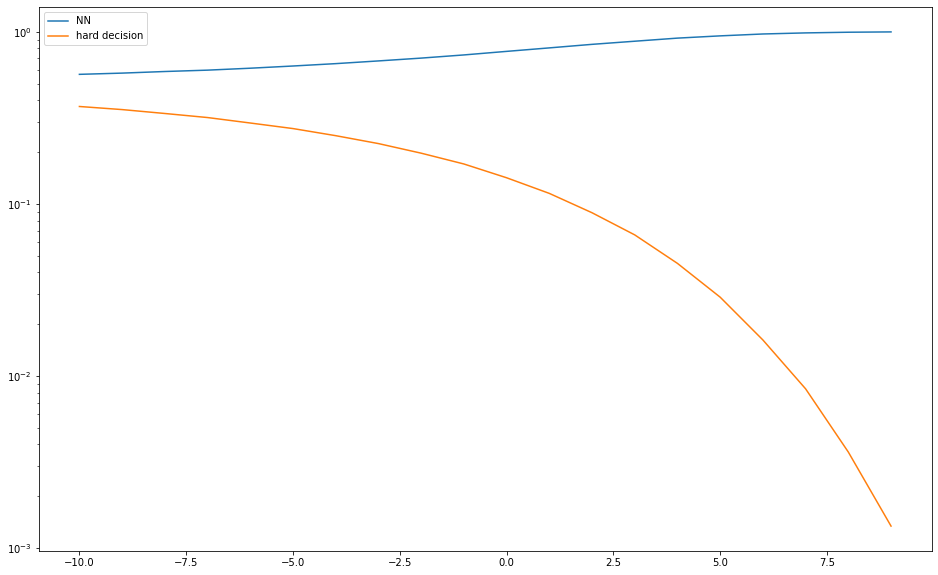

In [15]:
plt.figure(figsize=(16,10))
plt.semilogy(SNRs, (test_size*n - results_nn.numpy()) / (test_size*n), label='NN')
plt.semilogy(SNRs, (test_size*n - results_hard.numpy()) / (test_size*n), label='hard decision')
plt.legend()
plt.show()

In [11]:
decoder(soft_input)[0] - 0.5

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:1', grad_fn=<SubBackward0>)

In [12]:
codewords[0]

tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:1')

In [13]:
decoder.W_vc

Parameter containing:
tensor([[-0.6510, -3.1827, -2.5294,  0.6723,  1.4784,  2.5545,  0.9434,  2.5654,
          1.6559,  2.6246,  1.4692,  1.4508],
        [-1.0317, -0.0479,  2.3691, -0.4511,  0.4820, -1.0999,  1.4614, -2.1509,
          2.1552, -3.4284,  2.2952,  0.3389],
        [-1.6593, -2.8796,  1.8818, -1.3438, -0.7484,  2.5036,  2.1464,  0.6561,
          4.0739,  3.2363, -1.6556,  2.3673],
        [-1.1021, -2.6439,  1.8845,  0.8336,  2.8893, -4.4014,  1.6569, -1.5601,
          3.7244,  1.0861,  4.0938,  1.5546],
        [ 0.4948,  0.1329, -2.2415,  2.8786,  3.1903,  1.9015,  2.1405,  3.3994,
         -0.4039,  1.9769, -3.3160,  0.8218]], device='cuda:1',
       requires_grad=True)